In [377]:
!pip install tensorflow
!pip install kaggle

In [378]:
# ✅ Step 1: Download kaggle.json from GitHub only if not already present
import os

if not os.path.exists("/root/.kaggle/kaggle.json"):
    !mkdir -p ~/.kaggle
    !wget -q https://raw.githubusercontent.com/Ghulam-Mustafa-Rao/DeepLearningFinalProject/main/kaggle.json -O ~/.kaggle/kaggle.json
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("✅ kaggle.json already exists, skipping download.")

# ✅ Step 2: Install kaggle CLI
!pip install -q kaggle

# ✅ Step 3: Download competition dataset (force overwrite to suppress warnings)
if not os.path.exists("higgs-boson.zip"):
    !kaggle competitions download -c higgs-boson
else:
    print("✅ higgs-boson.zip already exists, skipping download.")

# ✅ Step 4: Unzip only if the target folder doesn’t already exist
if not os.path.exists("higgs_data/training.csv"):
    !rm -rf higgs_data  # optional: reset old data
    !unzip -o -q higgs-boson.zip -d higgs_data/
    !unzip -o -q higgs_data/training.zip -d higgs_data/
    !unzip -o -q higgs_data/test.zip -d higgs_data/
else:
    print("✅ Dataset already unzipped.")

# ✅ Step 5: Show the final contents
!ls higgs_data/


✅ kaggle.json already exists, skipping download.
✅ higgs-boson.zip already exists, skipping download.
✅ Dataset already unzipped.
HiggsBosonCompetition_AMSMetric_rev1.py  test.csv  training.csv
random_submission.zip			 test.zip  training.zip


In [379]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.utils import to_categorical

In [380]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [381]:
import tensorflow as tf


# 1. Data Preparation

In [382]:
!ls higgs_data

HiggsBosonCompetition_AMSMetric_rev1.py  test.csv  training.csv
random_submission.zip			 test.zip  training.zip


In [383]:
# !unzip -q higgs_data/training.zip -d higgs_data/
# !unzip -q higgs_data/test.zip -d higgs_data/

In [384]:
!ls higgs_data/

HiggsBosonCompetition_AMSMetric_rev1.py  test.csv  training.csv
random_submission.zip			 test.zip  training.zip


In [385]:
import pandas as pd

# Load training data
df = pd.read_csv("higgs_data/training.csv")

# Preview first few rows
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [386]:
df.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


In [387]:
import pandas as pd

# Suppose your DataFrame is called df

# Boolean mask of -999.0
mask = (df == -999.0)

# Count per column
counts = mask.sum()

# Percentage per column
percentages = 100 * counts / len(df)

# Combine counts and percentages in a DataFrame for clarity
result = pd.DataFrame({
    "Count": counts,
    "Percentage": percentages
})

print("Counts and percentages of -999.0 per column:")
print(result)


Counts and percentages of -999.0 per column:
                              Count  Percentage
EventId                           0      0.0000
DER_mass_MMC                  38114     15.2456
DER_mass_transverse_met_lep       0      0.0000
DER_mass_vis                      0      0.0000
DER_pt_h                          0      0.0000
DER_deltaeta_jet_jet         177457     70.9828
DER_mass_jet_jet             177457     70.9828
DER_prodeta_jet_jet          177457     70.9828
DER_deltar_tau_lep                0      0.0000
DER_pt_tot                        0      0.0000
DER_sum_pt                        0      0.0000
DER_pt_ratio_lep_tau              0      0.0000
DER_met_phi_centrality            0      0.0000
DER_lep_eta_centrality       177457     70.9828
PRI_tau_pt                        0      0.0000
PRI_tau_eta                       0      0.0000
PRI_tau_phi                       0      0.0000
PRI_lep_pt                        0      0.0000
PRI_lep_eta                       0      0.

In [388]:
# Drop columns with >50% missing
cols_to_drop = [
    "DER_deltaeta_jet_jet",
    "DER_mass_jet_jet",
    "DER_prodeta_jet_jet",
    "DER_lep_eta_centrality",
    "PRI_jet_subleading_pt",
    "PRI_jet_subleading_eta",
    "PRI_jet_subleading_phi"
]
df = df.drop(columns=cols_to_drop)

# Replace -999.0 in remaining columns with median
cols_with_neg999 = [
    "PRI_jet_leading_pt",
    "PRI_jet_leading_eta",
    "PRI_jet_leading_phi",
    "DER_mass_MMC"
]

# for col in cols_with_neg999:
#     median = df.loc[df[col] != -999.0, col].median()
#     df[col] = df[col].replace(-999.0, median)

In [389]:
df.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,...,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,2.373100,18.917332,158.432217,1.437609,-0.128305,...,0.043543,41.717235,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,0.782911,22.273494,115.706115,0.844743,1.193585,...,1.816611,32.894693,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,0.208000,0.000000,46.104000,0.047000,-1.414000,...,-3.142000,0.109000,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,1.810000,2.841000,77.550000,0.883000,-1.371000,...,-1.522000,21.398000,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,2.491500,12.315500,120.664500,1.280000,-0.356000,...,0.086000,34.802000,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,2.961000,27.591000,200.478250,1.777000,1.225000,...,1.618000,51.895000,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,5.684000,2834.999000,1852.462000,19.773000,1.414000,...,3.142000,2842.617000,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,1633.433000,7.822543


In [390]:
# Convert 'Label': 's' → 1 (signal), 'b' → 0 (background)
df['Label'] = df['Label'].map({'s': 1, 'b': 0})

# Separate features and labels
X = df.drop(columns=["EventId","Label"])
y = df["Label"]

print("X shape:", X.shape)
print("Class balance:\n", y.value_counts())


X shape: (250000, 24)
Class balance:
 Label
0    164333
1     85667
Name: count, dtype: int64


/tmp/ipython-input-391-2234974965.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')


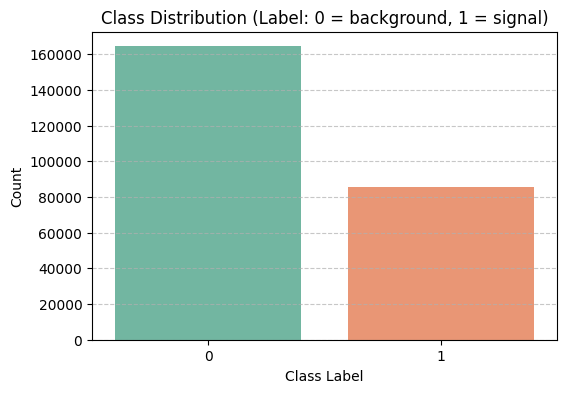

In [391]:
# Plot class balance
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='Set2')
plt.title("Class Distribution (Label: 0 = background, 1 = signal)")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [392]:
df.nunique()

,0
EventId,250000
DER_mass_MMC,108338
DER_mass_transverse_met_lep,101637
DER_mass_vis,100558
DER_pt_h,115563
DER_deltar_tau_lep,4692
DER_pt_tot,59042
DER_sum_pt,156098
DER_pt_ratio_lep_tau,5931
DER_met_phi_centrality,2829


• Handle any missing or zero-filled values (if present)

In [393]:
df.isnull().sum()

,0
EventId,0
DER_mass_MMC,0
DER_mass_transverse_met_lep,0
DER_mass_vis,0
DER_pt_h,0
DER_deltar_tau_lep,0
DER_pt_tot,0
DER_sum_pt,0
DER_pt_ratio_lep_tau,0
DER_met_phi_centrality,0


In [394]:
print(X.dtypes)

DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_leading_eta            float64
PRI_jet_leading_phi            float64
PRI_jet_all_pt                 float64
Weight                         float64
dtype: object


In [395]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DER_mass_MMC                 250000 non-null  float64
 1   DER_mass_transverse_met_lep  250000 non-null  float64
 2   DER_mass_vis                 250000 non-null  float64
 3   DER_pt_h                     250000 non-null  float64
 4   DER_deltar_tau_lep           250000 non-null  float64
 5   DER_pt_tot                   250000 non-null  float64
 6   DER_sum_pt                   250000 non-null  float64
 7   DER_pt_ratio_lep_tau         250000 non-null  float64
 8   DER_met_phi_centrality       250000 non-null  float64
 9   PRI_tau_pt                   250000 non-null  float64
 10  PRI_tau_eta                  250000 non-null  float64
 11  PRI_tau_phi                  250000 non-null  float64
 12  PRI_lep_pt                   250000 non-null  float64
 13 

In [396]:
# # Replace -999.0 with NaN
# X = X.replace(-999.0, np.nan)
# #
# # Count NaNs in each set
# X_nan_counts = X.isna().sum().sum()

# print(f"Total NaNs in X: {X_nan_counts}")

In [397]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DER_mass_MMC                 250000 non-null  float64
 1   DER_mass_transverse_met_lep  250000 non-null  float64
 2   DER_mass_vis                 250000 non-null  float64
 3   DER_pt_h                     250000 non-null  float64
 4   DER_deltar_tau_lep           250000 non-null  float64
 5   DER_pt_tot                   250000 non-null  float64
 6   DER_sum_pt                   250000 non-null  float64
 7   DER_pt_ratio_lep_tau         250000 non-null  float64
 8   DER_met_phi_centrality       250000 non-null  float64
 9   PRI_tau_pt                   250000 non-null  float64
 10  PRI_tau_eta                  250000 non-null  float64
 11  PRI_tau_phi                  250000 non-null  float64
 12  PRI_lep_pt                   250000 non-null  float64
 13 

In [398]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="median")

# X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [399]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DER_mass_MMC                 250000 non-null  float64
 1   DER_mass_transverse_met_lep  250000 non-null  float64
 2   DER_mass_vis                 250000 non-null  float64
 3   DER_pt_h                     250000 non-null  float64
 4   DER_deltar_tau_lep           250000 non-null  float64
 5   DER_pt_tot                   250000 non-null  float64
 6   DER_sum_pt                   250000 non-null  float64
 7   DER_pt_ratio_lep_tau         250000 non-null  float64
 8   DER_met_phi_centrality       250000 non-null  float64
 9   PRI_tau_pt                   250000 non-null  float64
 10  PRI_tau_eta                  250000 non-null  float64
 11  PRI_tau_phi                  250000 non-null  float64
 12  PRI_lep_pt                   250000 non-null  float64
 13 

In [400]:
X.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,...,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-49.023079,49.239819,81.181982,57.895962,2.373100,18.917332,158.432217,1.437609,-0.128305,38.707419,...,0.043543,41.717235,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,73.064591,1.646767
std,406.345647,35.344886,40.828691,63.655682,0.782911,22.273494,115.706115,0.844743,1.193585,22.412081,...,1.816611,32.894693,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,98.015662,1.875103
min,-999.000000,0.000000,6.329000,0.000000,0.208000,0.000000,46.104000,0.047000,-1.414000,20.000000,...,-3.142000,0.109000,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,78.100750,19.241000,59.388750,14.068750,1.810000,2.841000,77.550000,0.883000,-1.371000,24.591750,...,-1.522000,21.398000,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,105.012000,46.524000,73.752000,38.467500,2.491500,12.315500,120.664500,1.280000,-0.356000,31.804000,...,0.086000,34.802000,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,40.512500,1.156188
75%,130.606250,73.598000,92.259000,79.169000,2.961000,27.591000,200.478250,1.777000,1.225000,45.017000,...,1.618000,51.895000,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,109.933750,2.404128
max,1192.026000,690.075000,1349.351000,2834.999000,5.684000,2834.999000,1852.462000,19.773000,1.414000,764.408000,...,3.142000,2842.617000,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,1633.433000,7.822543


In [401]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [402]:
X_scaled.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,...,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.433576,0.071354,0.055735,0.020422,0.395380,0.006673,0.062185,0.070496,0.454631,0.025131,...,0.506929,0.014638,0.498390,0.098538,0.326392,0.306982,0.597654,0.598459,0.044731,0.210364
std,0.185459,0.051219,0.030401,0.022454,0.142971,0.007857,0.064055,0.042824,0.422060,0.030107,...,0.289085,0.011572,0.288387,0.063558,0.325809,0.251448,0.487632,0.488288,0.060006,0.239751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.491597,0.027882,0.039508,0.004963,0.292549,0.001002,0.017409,0.042381,0.015205,0.006168,...,0.257798,0.007490,0.249363,0.054936,0.000000,0.000000,0.000000,0.000000,0.000000,0.002191
50%,0.503879,0.067419,0.050202,0.013569,0.417001,0.004344,0.041277,0.062506,0.374116,0.015857,...,0.513686,0.012205,0.496181,0.083435,0.333333,0.489702,0.993651,0.994777,0.024802,0.147638
75%,0.515560,0.106652,0.063983,0.027926,0.502739,0.009732,0.085462,0.087702,0.933168,0.033607,...,0.757479,0.018218,0.748409,0.125459,0.666667,0.506870,0.995948,0.997368,0.067302,0.307200
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Train/validation/test split (e.g., 70/15/15)

In [403]:

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y  # ensures same class balance
)

# # Scale features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [404]:
continuous_features = [
    'DER_mass_MMC',
    'DER_mass_transverse_met_lep',
    'DER_mass_vis',
    'DER_pt_h',
    'DER_deltaeta_jet_jet',
    'DER_mass_jet_jet',
    'DER_prodeta_jet_jet',
    'DER_deltar_tau_lep',
    'DER_pt_tot',
    'DER_sum_pt',
    'DER_pt_ratio_lep_tau',
    'DER_met_phi_centrality',
    'DER_lep_eta_centrality',
    'PRI_tau_pt',
    'PRI_tau_eta',
    'PRI_tau_phi',
    'PRI_lep_pt',
    'PRI_lep_eta',
    'PRI_lep_phi',
    'PRI_met',
    'PRI_met_phi',
    'PRI_met_sumet',
    'PRI_jet_leading_pt',
    'PRI_jet_leading_eta',
    'PRI_jet_leading_phi',
    'PRI_jet_subleading_pt',
    'PRI_jet_subleading_eta',
    'PRI_jet_subleading_phi',
    'PRI_jet_all_pt',
    'Weight'
]


In [405]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)


In [406]:
print("Class balance:\n", y_train.value_counts())
print("Class balance:\n", y_val.value_counts())
print("Class balance:\n", y_test.value_counts())

Class balance:
 Label
0    115033
1     59967
Name: count, dtype: int64
Class balance:
 Label
0    24650
1    12850
Name: count, dtype: int64
Class balance:
 Label
0    24650
1    12850
Name: count, dtype: int64


In [407]:
print("Class balance:\n", y_train.shape)
print("Class balance:\n", y_val.shape)
print("Class balance:\n", y_test.shape)

Class balance:
 (175000,)
Class balance:
 (37500,)
Class balance:
 (37500,)


In [408]:
medians = X_train.replace(-999.0, np.nan).median()

In [409]:
X_train = X_train.replace(-999.0, medians)
X_val   = X_val.replace(-999.0, medians)
X_test  = X_test.replace(-999.0, medians)

• Normalize continuous features

In [410]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [411]:
# Verify normalization (mean ~0, std ~1 for numeric columns in train_split)
print("Training set numeric columns mean:\n", X_train.mean())
print("Training set numeric columns mean:\n", X_train.std())

Training set numeric columns mean:
 -5.547308644184211e-18
Training set numeric columns mean:
 1.0


In [412]:


# # 2. Impute
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="median")

# X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
# X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [413]:
# scaler = MinMaxScaler()

# # Fit on training set only
# X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])

# # Apply same transformation to val and test
# X_val[continuous_features] = scaler.transform(X_val[continuous_features])
# X_test[continuous_features] = scaler.transform(X_test[continuous_features])

In [414]:
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (175000, 24)
Validation: (37500, 24)
Test: (37500, 24)


In [454]:
duplicates_train = pd.DataFrame(X_train).duplicated().sum()
duplicates_test = pd.DataFrame(X_test).duplicated().sum()

In [455]:
print("Train duplicates:", duplicates_train)
print("Test duplicates:", duplicates_test)

Train duplicates: 0
Test duplicates: 0


#2. Model Building

• Define architecture
*   Hidden layers, units, activation functions
*   Output layer with sigmoid activation
*   Loss function: binary crossentropy



In [415]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam,AdamW
from sklearn.metrics import classification_report, confusion_matrix

In [416]:
baseline_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
baseline_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

• Set optimizer, learning rate, and epochs

In [417]:
baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy']
)

In [418]:

history_baseline = baseline_model.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      epochs=30,
                                      batch_size=128,
                                      verbose=1)

Epoch 1/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8928 - loss: 0.2392 - val_accuracy: 0.9615 - val_loss: 0.1009
Epoch 2/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9648 - loss: 0.0922 - val_accuracy: 0.9693 - val_loss: 0.0807
Epoch 3/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9691 - loss: 0.0789 - val_accuracy: 0.9742 - val_loss: 0.0699
Epoch 4/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9730 - loss: 0.0707 - val_accuracy: 0.9747 - val_loss: 0.0673
Epoch 5/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9767 - loss: 0.0615 - val_accuracy: 0.9787 - val_loss: 0.0573
Epoch 6/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9792 - loss: 0.0542 - val_accuracy: 0.9818 - val_loss: 0.0486
Epoch 7/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9829 - loss: 0.0454 - val_accuracy: 0.9815 - val_loss: 0.0488
Epoch 8/30
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9862 - loss: 0.0386 

In [419]:
def plot_learning_curves(history, title='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r--', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

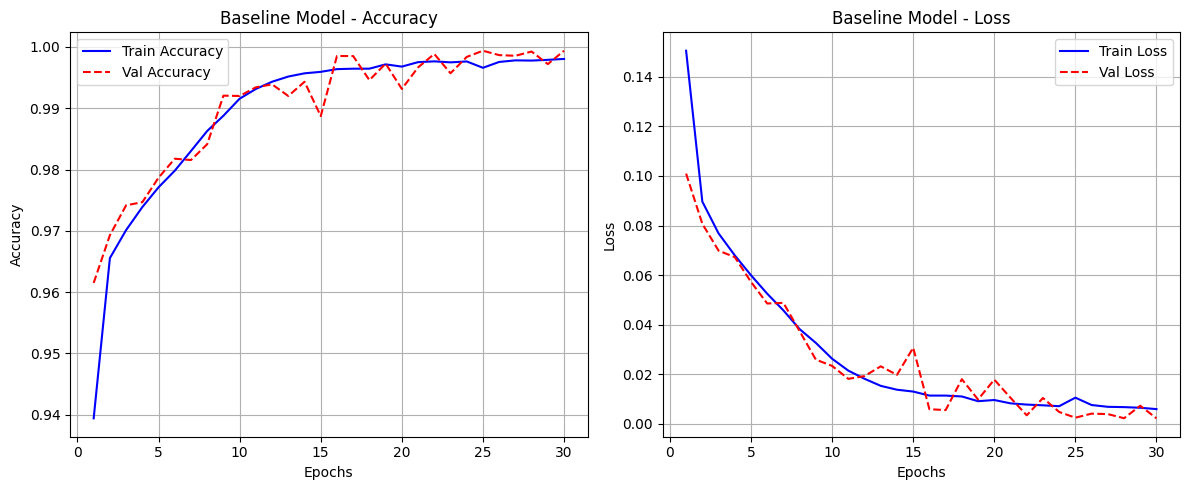

In [420]:
plot_learning_curves(history_baseline, title='Baseline Model')

In [421]:
y_pred = (baseline_model.predict(X_test) > 0.5).astype("int32")

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   


In [422]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24650
           1       1.00      1.00      1.00     12850

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500



In [423]:
loss1, acc1 = baseline_model.evaluate(X_test, y_test)
print(f"Test accuracy : {100*acc1:.2f}%")
print(f"Test loss     : {100*loss1:.2f}%")

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9988 - loss: 0.0033
Test accuracy : 99.90%
Test loss     : 0.28%


• Apply regularization techniques (Dropout, BatchNorm, etc.)

Only BatchNorm


In [424]:
baseline_model_batchNorm = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    BatchNormalization(),
    layers.Dense(32, activation='relu'),
    BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])
baseline_model_batchNorm.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 192 (768.00 B)

In [425]:
baseline_model_batchNorm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy']
)

In [426]:

history_baseline_batchNorm = baseline_model_batchNorm.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      epochs=30,
                                      batch_size=256,
                                      verbose=1)

Epoch 1/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8722 - loss: 0.2836 - val_accuracy: 0.9695 - val_loss: 0.0852
Epoch 2/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9676 - loss: 0.0854 - val_accuracy: 0.9792 - val_loss: 0.0595
Epoch 3/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9774 - loss: 0.0601 - val_accuracy: 0.9885 - val_loss: 0.0427
Epoch 4/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9868 - loss: 0.0360 - val_accuracy: 0.9949 - val_loss: 0.0169
Epoch 5/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9932 - loss: 0.0203 - val_accuracy: 0.9860 - val_loss: 0.0369
Epoch 6/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 0.9974 - val_loss: 0.0089
Epoch 7/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9979 - loss: 0.0070 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 8/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9980 - loss: 0.0064 - val_accuracy: 0.

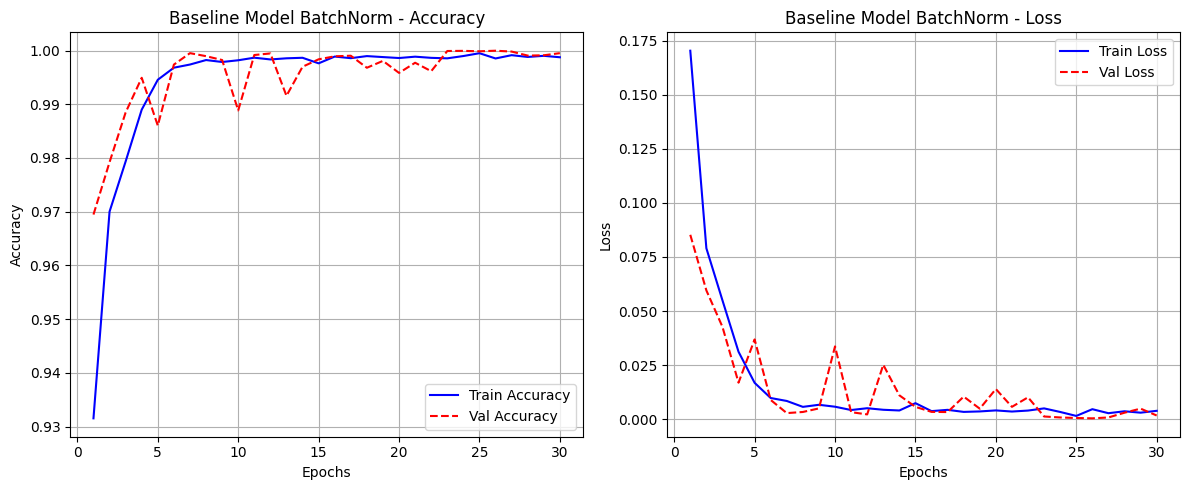

In [427]:
plot_learning_curves(history_baseline_batchNorm, title='Baseline Model BatchNorm')

In [428]:
loss1, acc1 = baseline_model_batchNorm.evaluate(X_test, y_test)
print(f"Test accuracy : {100*acc1:.2f}%")
print(f"Test loss     : {100*loss1:.2f}%")

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9990 - loss: 0.0038
Test accuracy : 99.91%
Test loss     : 0.29%


BatchNorm + Dropout

In [429]:
baseline_model_batchNorm_Dropout = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    layers.Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])
baseline_model_batchNorm_Dropout.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 192 (768.00 B)

In [430]:
baseline_model_batchNorm_Dropout.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy']
)

In [431]:

history_baseline_batchNorm_Dropout = baseline_model_batchNorm_Dropout.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      epochs=30,
                                      batch_size=256,
                                      verbose=1)

Epoch 1/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8487 - loss: 0.3250 - val_accuracy: 0.9578 - val_loss: 0.1110
Epoch 2/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9671 - loss: 0.0855 - val_accuracy: 0.9867 - val_loss: 0.0457
Epoch 3/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9875 - loss: 0.0343 - val_accuracy: 0.9856 - val_loss: 0.0364
Epoch 4/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9927 - loss: 0.0202 - val_accuracy: 0.9983 - val_loss: 0.0056
Epoch 5/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9947 - loss: 0.0152 - val_accuracy: 0.9975 - val_loss: 0.0097
Epoch 6/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9954 - loss: 0.0130 - val_accuracy: 0.9985 - val_loss: 0.0056
Epoch 7/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9962 - loss: 0.0104 - val_accuracy: 0.9972 - val_loss: 0.0091
Epoch 8/30
684/684 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9944 - loss: 0.0180 - val_accuracy: 0.

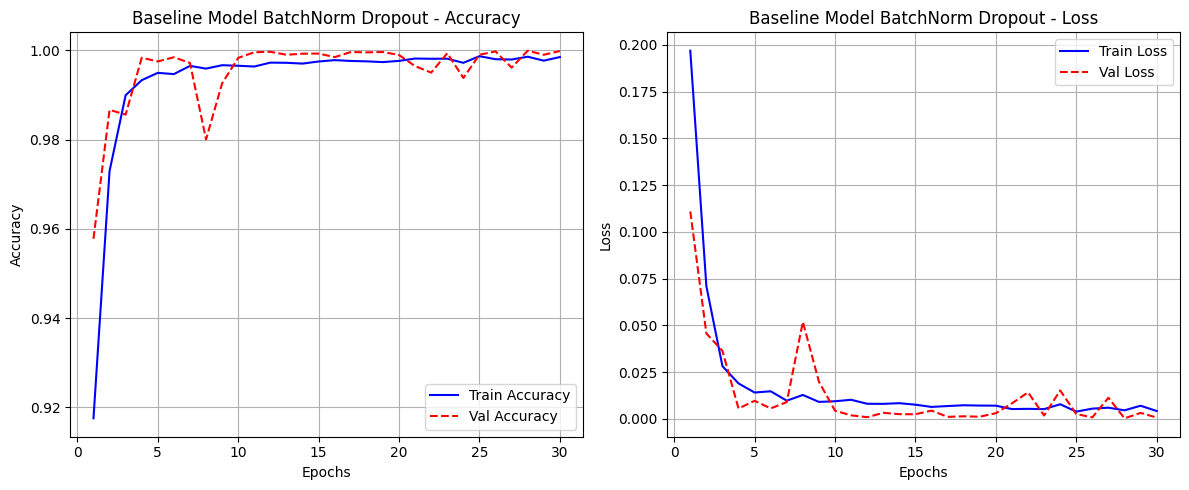

In [432]:
plot_learning_curves(history_baseline_batchNorm_Dropout, title='Baseline Model BatchNorm Dropout')

In [433]:
loss1, acc1 = baseline_model_batchNorm_Dropout.evaluate(X_test, y_test)
print(f"Test accuracy : {100*acc1:.2f}%")
print(f"Test loss     : {100*loss1:.2f}%")

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 0.0013
Test accuracy : 99.98%
Test loss     : 0.10%


• Use callbacks: EarlyStopping, ReduceLROnPlateau

In [434]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [435]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [436]:
baseline_model_batchNorm_Dropout_callbacks = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    layers.Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])
baseline_model_batchNorm_Dropout.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,909 (46.52 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 7,812 (30.52 KB)

In [437]:
baseline_model_batchNorm_Dropout_callbacks.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy']
)

In [438]:

history_baseline_batchNorm_Dropout_callbacks = baseline_model_batchNorm_Dropout_callbacks.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      epochs=60,
                                      batch_size=256,
                                      callbacks=[reduce_lr, checkpoint, early_stop],
                                      verbose=1)

Epoch 1/60
676/684 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8363 - loss: 0.3513
Epoch 1: val_loss improved from inf to 0.09833, saving model to best_model.keras
684/684 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8373 - loss: 0.3495 - val_accuracy: 0.9638 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 2/60
677/684 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9577 - loss: 0.1095
Epoch 2: val_loss improved from 0.09833 to 0.08758, saving model to best_model.keras
684/684 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9578 - loss: 0.1094 - val_accuracy: 0.9669 - val_loss: 0.0876 - learning_rate: 0.0010
Epoch 3/60
679/684 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9769 - loss: 0.0598
Epoch 3: val_loss improved from 0.08758 to 0.00774, saving model to best_model.keras
684/684 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9770 - loss: 0.0597 - val_accuracy: 0.9982 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 4/60
683/684 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.99

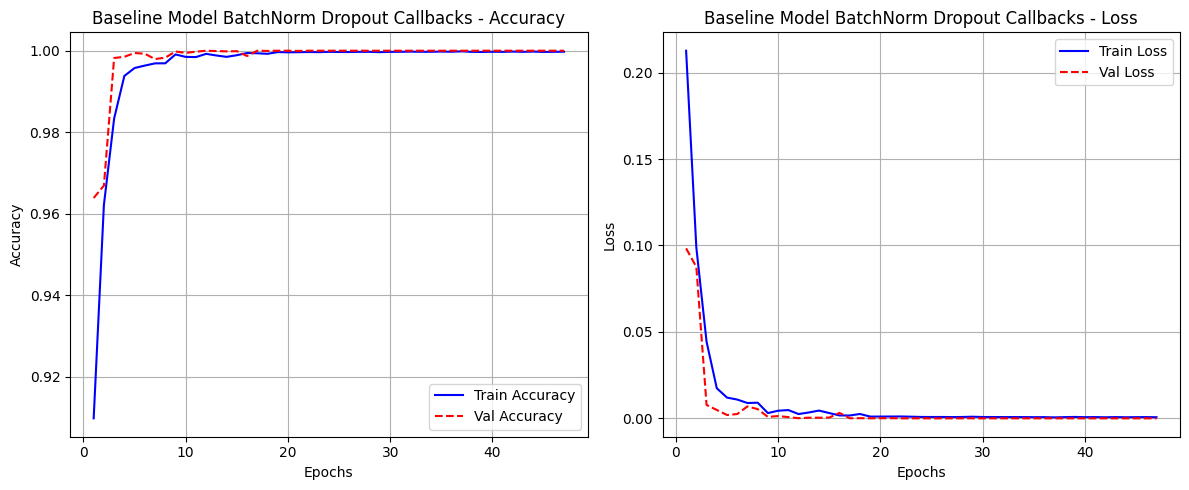

In [439]:
plot_learning_curves(history_baseline_batchNorm_Dropout_callbacks, title='Baseline Model BatchNorm Dropout Callbacks')

In [440]:
loss1, acc1 = baseline_model_batchNorm_Dropout_callbacks.evaluate(X_test, y_test)
print(f"Test accuracy : {100*acc1:.2f}%")
print(f"Test loss     : {100*loss1:.2f}%")

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 7.2873e-06
Test accuracy : 100.00%
Test loss     : 0.00%


• Try a deeper architecture or a different optimizer (RMSprop, AdamW)

In [441]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [442]:
baseline_model_batchNorm_Dropout_callbacks_Deeper = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    layers.Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    layers.Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    layers.Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])
baseline_model_batchNorm_Dropout_callbacks_Deeper.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 256)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,585 (201.50 KB)

 Trainable params: 50,625 (197.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [443]:
baseline_model_batchNorm_Dropout_callbacks_Deeper.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5),
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy']
)

In [444]:
history_baseline_batchNorm_Dropout_callbacks_Deeper = baseline_model_batchNorm_Dropout_callbacks_Deeper.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      epochs=60,
                                      batch_size=256,
                                      callbacks=[reduce_lr, checkpoint, early_stop],
                                      verbose=1)

Epoch 1/60
684/684 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9004 - loss: 0.2376
Epoch 1: val_loss improved from inf to 0.09095, saving model to best_model.keras
684/684 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9005 - loss: 0.2375 - val_accuracy: 0.9661 - val_loss: 0.0910 - learning_rate: 0.0010
Epoch 2/60
680/684 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9630 - loss: 0.0977
Epoch 2: val_loss improved from 0.09095 to 0.07930, saving model to best_model.keras
684/684 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9630 - loss: 0.0976 - val_accuracy: 0.9687 - val_loss: 0.0793 - learning_rate: 0.0010
Epoch 3/60
680/684 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9726 - loss: 0.0707
Epoch 3: val_loss improved from 0.07930 to 0.07355, saving model to best_model.keras
684/684 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9726 - loss: 0.0706 - val_accuracy: 0.9709 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 4/60
683/684 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy

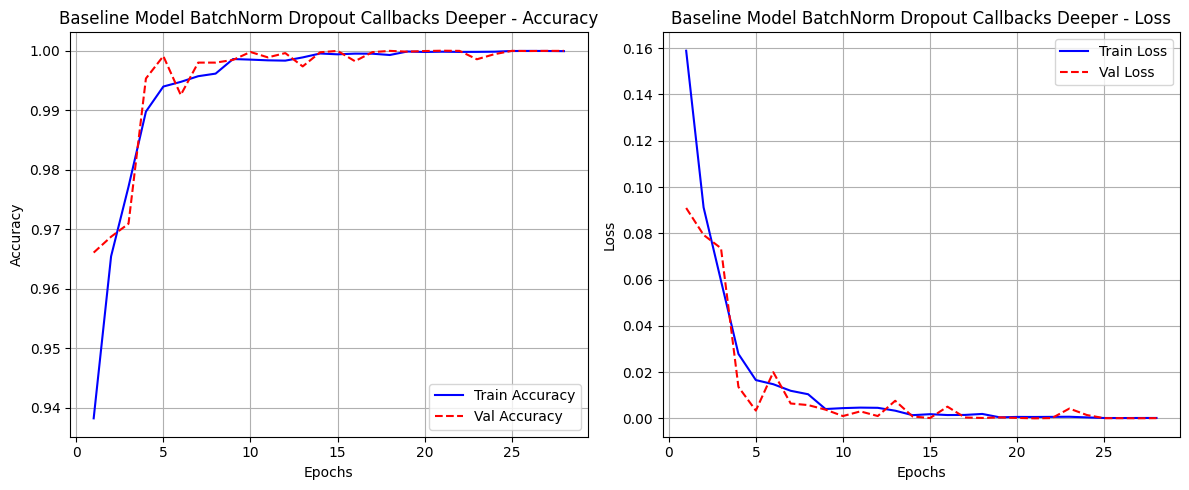

In [445]:
plot_learning_curves(history_baseline_batchNorm_Dropout_callbacks_Deeper, title='Baseline Model BatchNorm Dropout Callbacks Deeper')

In [446]:
loss1, acc1 = baseline_model_batchNorm_Dropout_callbacks_Deeper.evaluate(X_test, y_test)
print(f"Test accuracy : {100*acc1:.2f}%")
print(f"Test loss     : {100*loss1:.2f}%")

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 1.1573e-04
Test accuracy : 100.00%
Test loss     : 0.01%


#3. Model Evaluation

• Plot training and validation accuracy/ loss curves

In [447]:
models_dict = {
    "Baseline": baseline_model,
    "BatchNorm": baseline_model_batchNorm,
    "BatchNorm + Dropout": baseline_model_batchNorm_Dropout,
    "BatchNorm + Dropout + Callbacks": baseline_model_batchNorm_Dropout_callbacks,
    "BatchNorm + Dropout + Callbacks + Deeper": baseline_model_batchNorm_Dropout_callbacks_Deeper,
}
histories = {
    "Baseline": history_baseline,
    "BatchNorm": history_baseline_batchNorm,
    "BatchNorm + Dropout": history_baseline_batchNorm_Dropout,
    "BatchNorm + Dropout + Callbacks": history_baseline_batchNorm_Dropout_callbacks,
    "BatchNorm + Dropout + Callbacks + Deeper": history_baseline_batchNorm_Dropout_callbacks_Deeper,
}

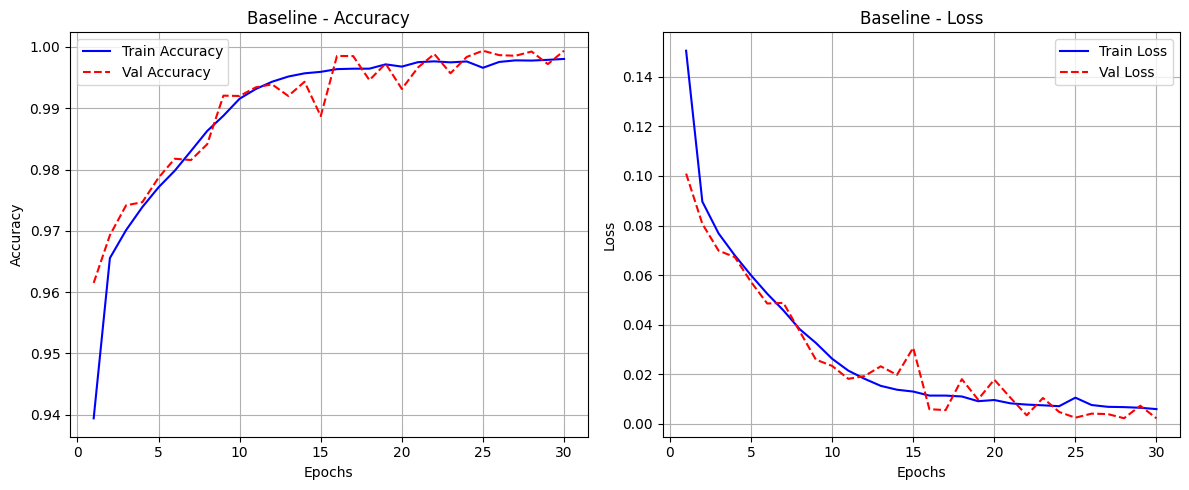

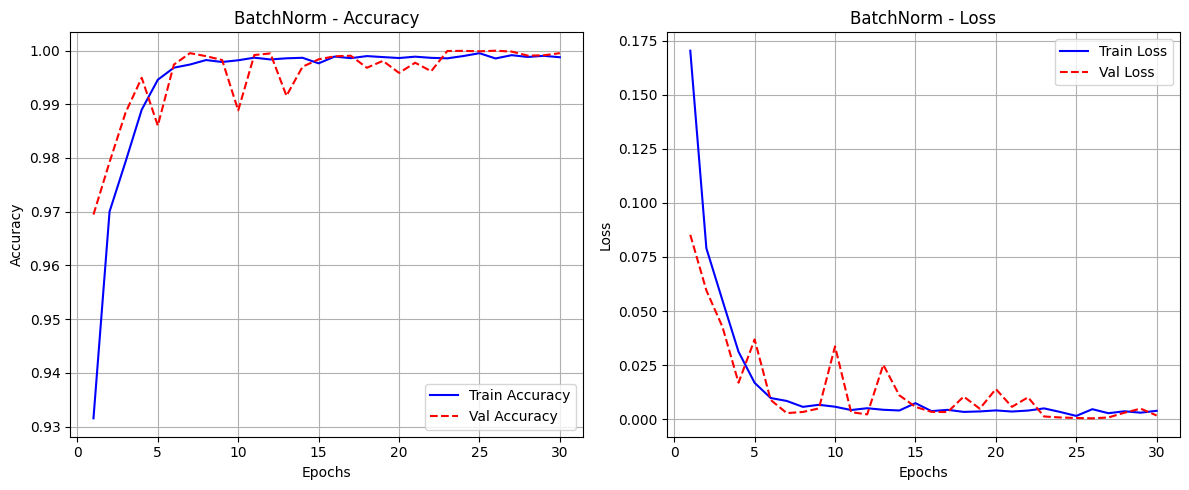

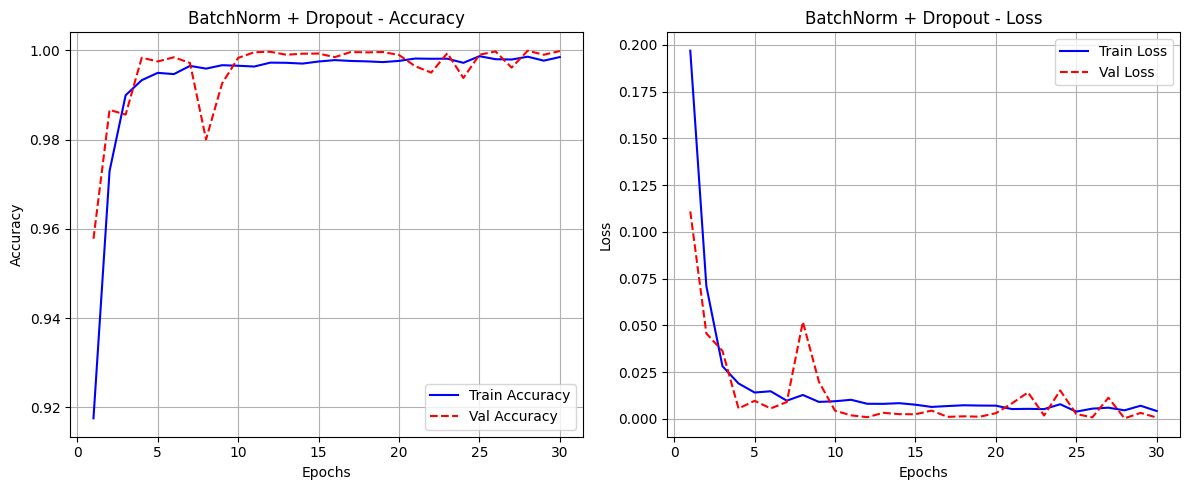

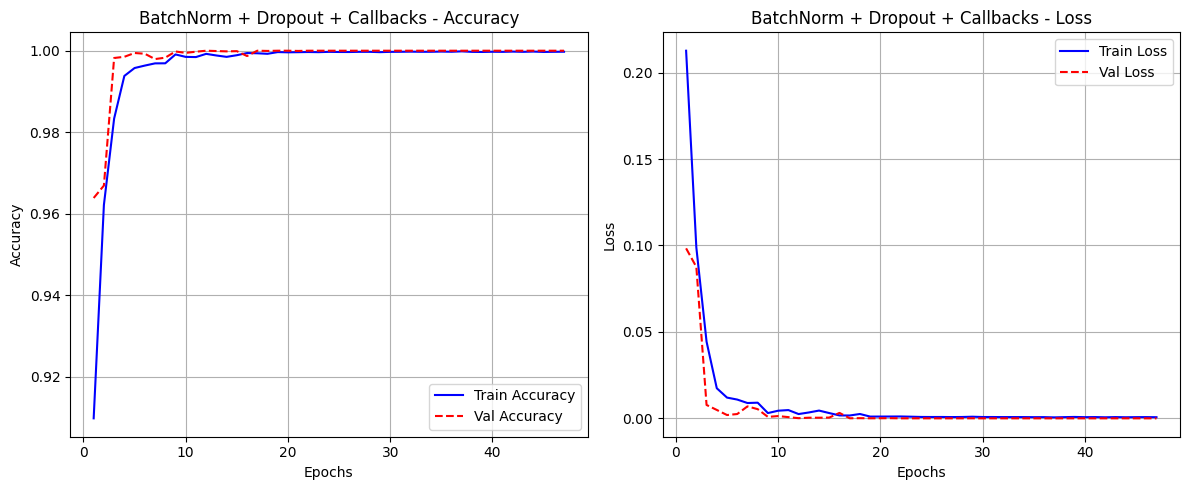

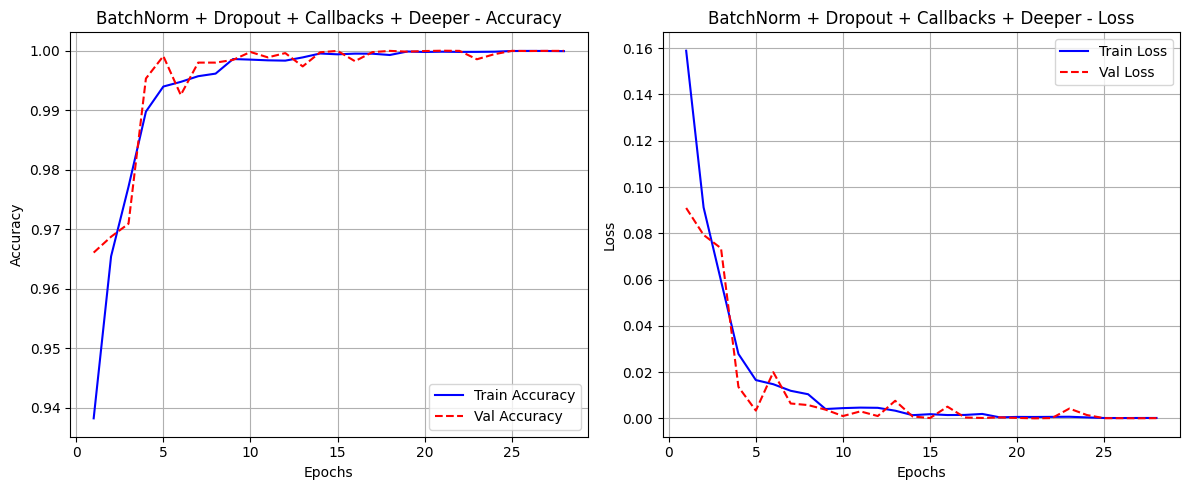

In [448]:
for name, history in histories.items():
    plot_learning_curves(history, title=name)


• Report performance on dataset using:


o accuracy


o precision, recall and F-1 score


o Confusion matrix and ROC-AUC curve

In [449]:
results = []

for name, model in models_dict.items():
    history = histories[name]
    num_epochs = len(history.epoch)

    # Evaluate accuracy & loss
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    # Predict and calculate metrics
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    print("\nClassification Report:\n")
    print("\nModel': "+name+"\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    # Get last training and validation accuracy from history
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    # Determine overfitting and underfitting (you can adjust these thresholds)
    overfitting = (train_acc - val_acc) > 0.05
    underfitting = (train_acc < 0.85) and (val_acc < 0.85)

    # Append result
    results.append({
        'Model': name,
        'Epochs Trained': num_epochs,
        'Test Accuracy': test_acc,
        'Test Loss': test_loss,
        'Precision (Macro)': report['macro avg']['precision'],
        'Recall (Macro)': report['macro avg']['recall'],
        'F1-score (Macro)': report['macro avg']['f1-score'],
        'Precision (Weighted)': report['weighted avg']['precision'],
        'Recall (Weighted)': report['weighted avg']['recall'],
        'F1-score (Weighted)': report['weighted avg']['f1-score'],
        'Overfitting': overfitting,
        'Underfitting': underfitting
    })



1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report:


Model': Baseline

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24650
           1       1.00      1.00      1.00     12850

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report:


Model': BatchNorm

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24650
           1       1.00      1.00      1.00     12850

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report:


Model': BatchNorm + Dropout

              precision    recall  f1-score   support

           0      

In [450]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Test Accuracy", ascending=False)
results_df

,Model,Epochs Trained,Test Accuracy,Test Loss,Precision (Macro),Recall (Macro),F1-score (Macro),Precision (Weighted),Recall (Weighted),F1-score (Weighted),Overfitting,Underfitting
3,BatchNorm + Dropout + Callbacks,47,1.000000,0.000007,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False
4,BatchNorm + Dropout + Callbacks + Deeper,28,0.999973,0.000082,0.999980,0.999961,0.999970,0.999973,0.999973,0.999973,False,False
2,BatchNorm + Dropout,30,0.999760,0.001036,0.999780,0.999687,0.999734,0.999760,0.999760,0.999760,False,False
1,BatchNorm,30,0.999120,0.002875,0.998848,0.999200,0.999024,0.999121,0.999120,0.999120,False,False
0,Baseline,30,0.998987,0.002823,0.998987,0.998764,0.998875,0.998987,0.998987,0.998987,False,False


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


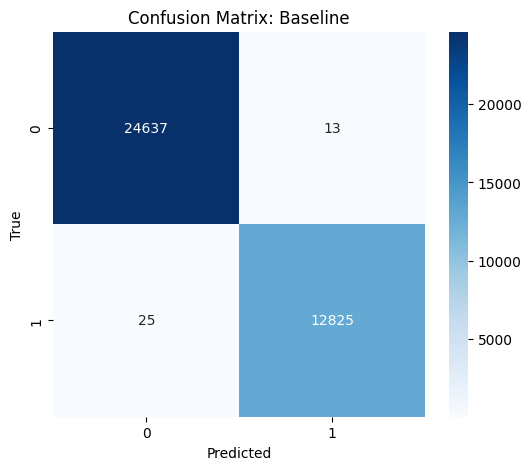

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


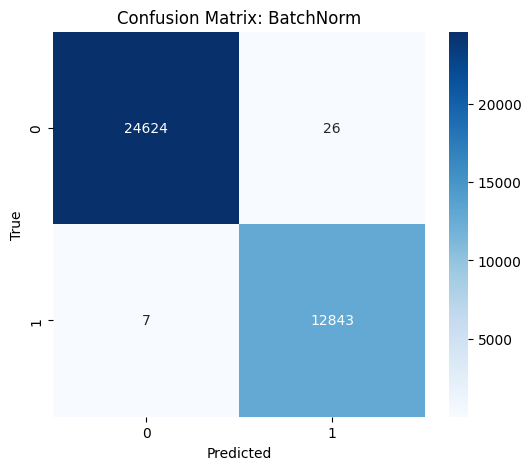

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


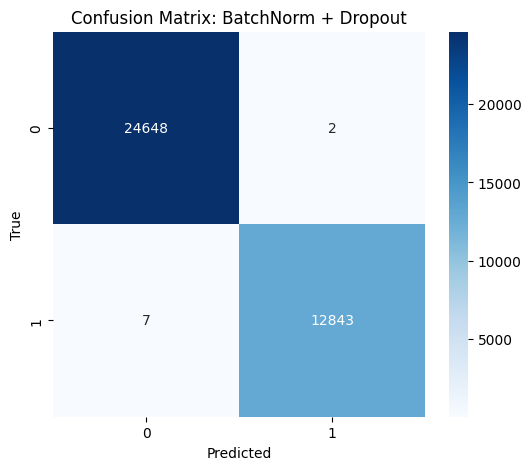

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


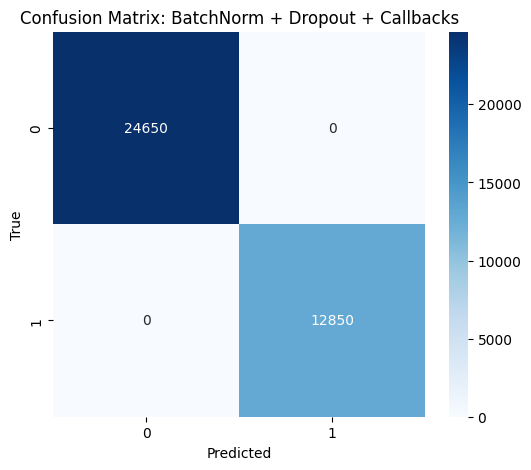

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


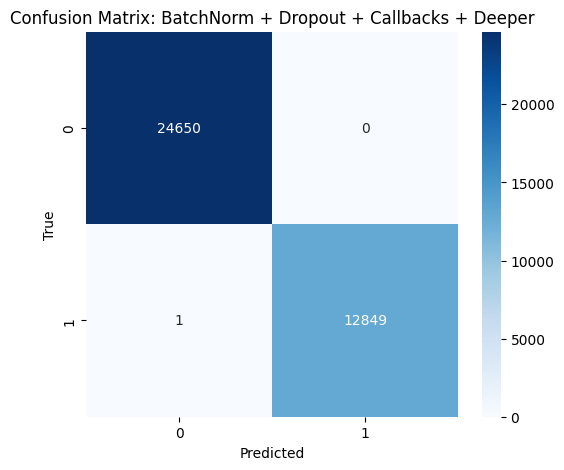

In [451]:
for name, model in models_dict.items():
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


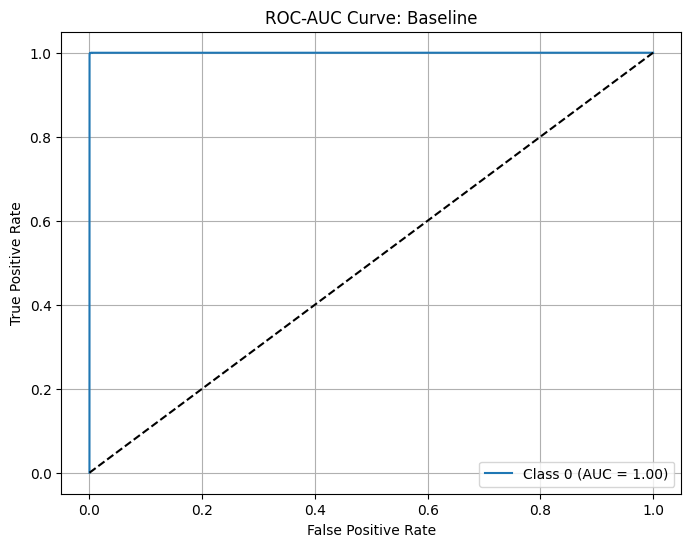

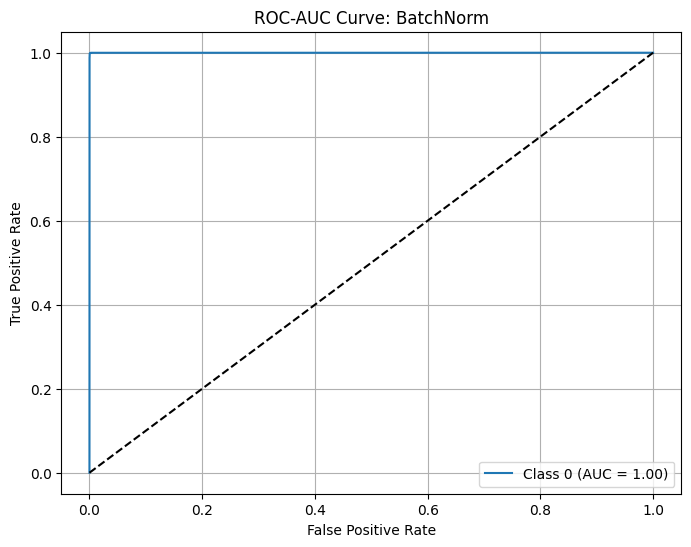

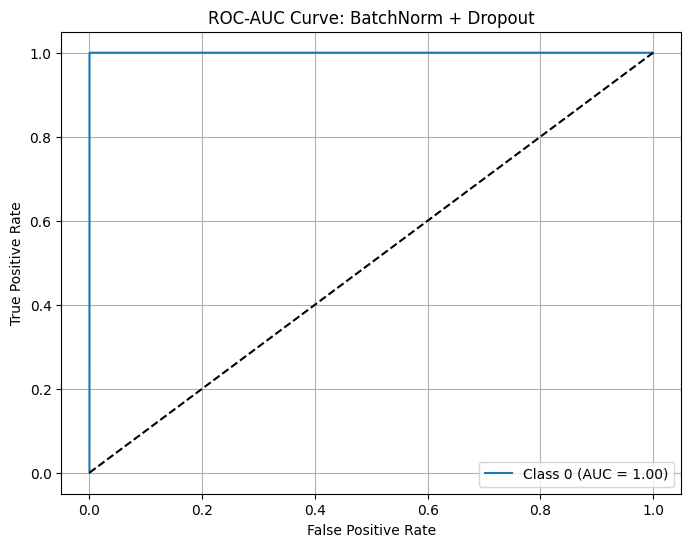

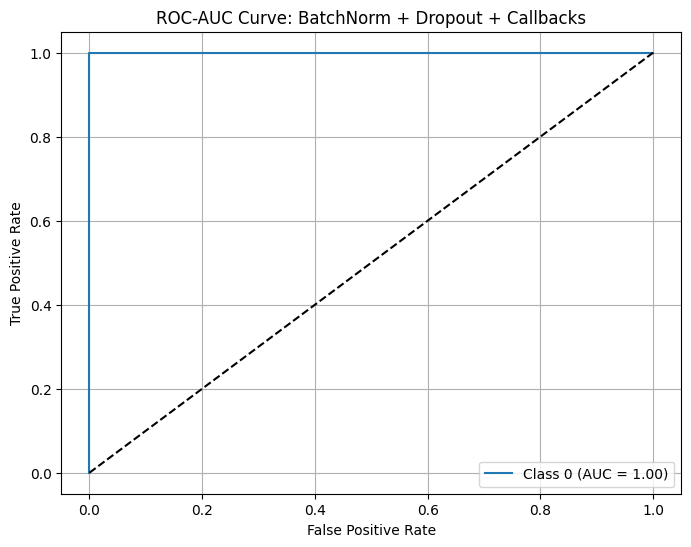

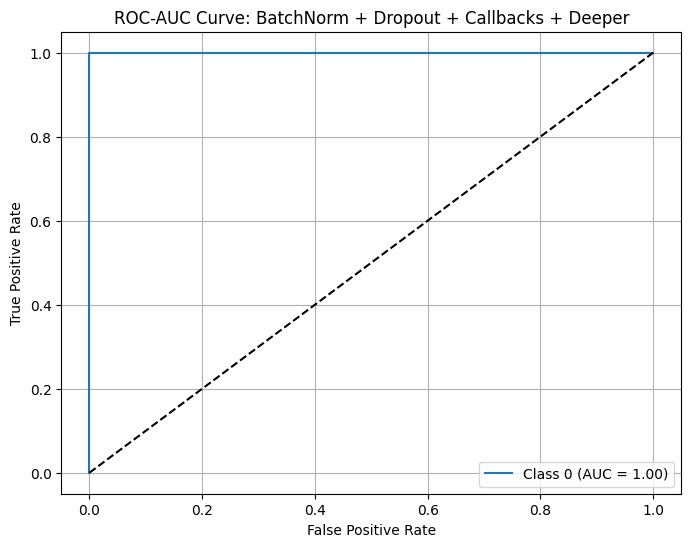

In [452]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming y_test has integer labels: [0, 1, 2, ...]
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

for name, model in models_dict.items():
    # Get predicted probabilities
    y_score = model.predict(X_test, verbose=0)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC-AUC Curve: {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


• Compare performance with a tree-based baseline

In [453]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest on training data
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Evaluate on test data
rf_preds = rf_clf.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test, rf_preds)
print(f"Random Forest Test Accuracy: {100 * rf_acc:.2f}%")

# Classification report (optional, for detailed comparison)
print("\nClassification Report:\n")
print(classification_report(y_test, rf_preds))


Random Forest Test Accuracy: 100.00%

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24650
           1       1.00      1.00      1.00     12850

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500

